### Libraries

In [1]:
import csv
import holidays
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from  lightgbm import LGBMRegressor
import os
import horizon
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_consistent_length, check_array
from sklearn.metrics import mean_squared_log_error

### MAPE code 

In [2]:
def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

In [3]:
def mean_absolute_percentage_error(y_true, y_pred,sample_weight=None,multioutput='uniform_average'):
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
    y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

### Reading csv files for 3 items(synapse extract)

In [4]:
items = pd.read_csv("../data/CompleteList.csv")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
items.head()

,ORGANIZATION_CODE,ORGANIZATION_ID,PARTITION_ID,TRANSACTION_ID,TRANSACTION_DATE,ITEM_NUMBER,GL_LOCATION,GL_ACCOUNT,GL_DEPARTMENT,GL_PCL,...,PRIMARY_UNIT_OF_MEASURE,TRANSACTION_SOURCE_TYPE_NAME,TRANSACTION_TYPE_NAME,TRANSACTION_ACTION,SUBINVENTORY_CODE,LOCATOR,LPN,TRANSFER_LPN,TRANSFER_ORG,TRANSFER_SUBINVENTORY
0,STN,87,289,144696799,2013-08-14T08:40:14.0000000,844600,25,41000,0,76,...,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,NaN,NaN,NaN,NaN,NaN
1,STN,87,289,144988032,2013-08-16T15:16:10.0000000,844600,25,41000,0,76,...,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,NaN,NaN,NaN,NaN,NaN
2,STN,87,289,144988050,2013-08-16T15:19:22.0000000,844600,25,41000,0,76,...,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,NaN,NaN,NaN,NaN,NaN
3,STN,87,289,144989708,2013-08-16T17:04:11.0000000,844600,25,41000,0,76,...,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,NaN,NaN,NaN,NaN,NaN
4,STN,87,289,144989744,2013-08-16T17:09:59.0000000,844600,25,41000,0,76,...,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,NaN,NaN,NaN,NaN,NaN


In [6]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ORGANIZATION_CODE             77409 non-null  object 
 1   ORGANIZATION_ID               77409 non-null  int64  
 2   PARTITION_ID                  77409 non-null  int64  
 3   TRANSACTION_ID                77409 non-null  int64  
 4   TRANSACTION_DATE              77409 non-null  object 
 5   ITEM_NUMBER                   77409 non-null  int64  
 6   GL_LOCATION                   77409 non-null  int64  
 7   GL_ACCOUNT                    77409 non-null  int64  
 8   GL_DEPARTMENT                 77409 non-null  int64  
 9   GL_PCL                        77409 non-null  int64  
 10  PARENT_TRANSACTION_ID         0 non-null      float64
 11  DEPARTMENT_CODE               73185 non-null  object 
 12  ACTUAL_COST                   77409 non-null  float64
 13  C

### Eliminating unnecessary columns

In [7]:
drop_columns = ['ORGANIZATION_ID','PARTITION_ID','GL_PCL','PARENT_TRANSACTION_ID','CURRENCY_CODE','SERIAL_NUMBERS',
               'TRANSACTION_SOURCE_NAME','SHIPMENT_NUMBER','TRANSFER_TRANSACTION_ID','TRANSFER_LOCATOR','LPN','TRANSFER_LPN',
               'TRANSFER_ORG','TRANSFER_SUBINVENTORY']
items = items.drop(drop_columns,axis=1)

In [8]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ORGANIZATION_CODE             77409 non-null  object 
 1   TRANSACTION_ID                77409 non-null  int64  
 2   TRANSACTION_DATE              77409 non-null  object 
 3   ITEM_NUMBER                   77409 non-null  int64  
 4   GL_LOCATION                   77409 non-null  int64  
 5   GL_ACCOUNT                    77409 non-null  int64  
 6   GL_DEPARTMENT                 77409 non-null  int64  
 7   DEPARTMENT_CODE               73185 non-null  object 
 8   ACTUAL_COST                   77409 non-null  float64
 9   GL_COMPANY                    77409 non-null  int64  
 10  TRANSACTION_SOURCE_ID         77409 non-null  int64  
 11  SOURCE_CODE                   77388 non-null  object 
 12  SOURCE_LINE_ID                77388 non-null  float64
 13  P

In [9]:
unequalColumns = ['DEPARTMENT_CODE','LOCATOR','SOURCE_CODE','SOURCE_LINE_ID']
items = items.drop(unequalColumns,axis=1)

In [10]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ORGANIZATION_CODE             77409 non-null  object 
 1   TRANSACTION_ID                77409 non-null  int64  
 2   TRANSACTION_DATE              77409 non-null  object 
 3   ITEM_NUMBER                   77409 non-null  int64  
 4   GL_LOCATION                   77409 non-null  int64  
 5   GL_ACCOUNT                    77409 non-null  int64  
 6   GL_DEPARTMENT                 77409 non-null  int64  
 7   ACTUAL_COST                   77409 non-null  float64
 8   GL_COMPANY                    77409 non-null  int64  
 9   TRANSACTION_SOURCE_ID         77409 non-null  int64  
 10  PRIMARY_QUANTITY              77409 non-null  float64
 11  PRIMARY_UNIT_OF_MEASURE       77409 non-null  object 
 12  TRANSACTION_SOURCE_TYPE_NAME  77409 non-null  object 
 13  T

### **Correlation between fields**

In [11]:
items.corr()

,TRANSACTION_ID,ITEM_NUMBER,GL_LOCATION,GL_ACCOUNT,GL_DEPARTMENT,ACTUAL_COST,GL_COMPANY,TRANSACTION_SOURCE_ID,PRIMARY_QUANTITY
TRANSACTION_ID,1.000000,0.031314,0.210953,NaN,NaN,0.144885,0.125933,0.944669,-0.173768
ITEM_NUMBER,0.031314,1.000000,0.010723,NaN,NaN,0.026103,-0.003357,0.039706,-0.388503
GL_LOCATION,0.210953,0.010723,1.000000,NaN,NaN,0.929151,0.956667,0.174361,-0.177335
GL_ACCOUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GL_DEPARTMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACTUAL_COST,0.144885,0.026103,0.929151,NaN,NaN,1.000000,0.973064,0.091546,-0.073101
GL_COMPANY,0.125933,-0.003357,0.956667,NaN,NaN,0.973064,1.000000,0.082255,-0.058512
TRANSACTION_SOURCE_ID,0.944669,0.039706,0.174361,NaN,NaN,0.091546,0.082255,1.000000,-0.181820
PRIMARY_QUANTITY,-0.173768,-0.388503,-0.177335,NaN,NaN,-0.073101,-0.058512,-0.181820,1.000000


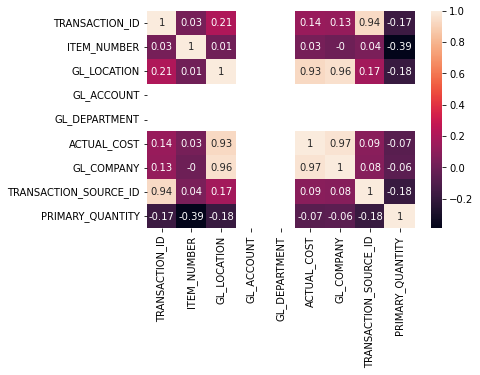

In [12]:
sns.heatmap(np.round(items.corr(),2), annot=True)

### Splitting date time field into different fields

In [13]:
items['TRANSACTION_DATE']

0        2013-08-14T08:40:14.0000000
1        2013-08-16T15:16:10.0000000
2        2013-08-16T15:19:22.0000000
3        2013-08-16T17:04:11.0000000
4        2013-08-16T17:09:59.0000000
                    ...             
77404    2021-09-03T06:31:37.0000000
77405    2021-09-03T06:37:31.0000000
77406    2021-09-03T10:52:59.0000000
77407    2021-09-03T11:09:33.0000000
77408    2021-09-03T11:57:22.0000000
Name: TRANSACTION_DATE, Length: 77409, dtype: object

In [14]:
items['DATE'] = pd.to_datetime(items['TRANSACTION_DATE']).dt.date

In [15]:
items['TIME'] = pd.to_datetime(items['TRANSACTION_DATE']).dt.time

In [16]:
items['SOLDUNITS'] = items['PRIMARY_QUANTITY'].apply(lambda x : abs(x))

In [17]:
items.head()

,ORGANIZATION_CODE,TRANSACTION_ID,TRANSACTION_DATE,ITEM_NUMBER,GL_LOCATION,GL_ACCOUNT,GL_DEPARTMENT,ACTUAL_COST,GL_COMPANY,TRANSACTION_SOURCE_ID,PRIMARY_QUANTITY,PRIMARY_UNIT_OF_MEASURE,TRANSACTION_SOURCE_TYPE_NAME,TRANSACTION_TYPE_NAME,TRANSACTION_ACTION,SUBINVENTORY_CODE,DATE,TIME,SOLDUNITS
0,STN,144696799,2013-08-14T08:40:14.0000000,844600,25,41000,0,0.39425,1,4435091,-2.85714,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,2013-08-14,08:40:14,2.85714
1,STN,144988032,2013-08-16T15:16:10.0000000,844600,25,41000,0,0.39425,1,4439094,-15.60000,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,2013-08-16,15:16:10,15.60000
2,STN,144988050,2013-08-16T15:19:22.0000000,844600,25,41000,0,0.39425,1,4439093,-15.60000,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,2013-08-16,15:19:22,15.60000
3,STN,144989708,2013-08-16T17:04:11.0000000,844600,25,41000,0,0.39425,1,4437499,-716.91429,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,2013-08-16,17:04:11,716.91429
4,STN,144989744,2013-08-16T17:09:59.0000000,844600,25,41000,0,0.39425,1,4437498,-153.14286,POUND,Job or Schedule,WIP Issue,Issue from stores,LC16,2013-08-16,17:09:59,153.14286


In [18]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ORGANIZATION_CODE             77409 non-null  object 
 1   TRANSACTION_ID                77409 non-null  int64  
 2   TRANSACTION_DATE              77409 non-null  object 
 3   ITEM_NUMBER                   77409 non-null  int64  
 4   GL_LOCATION                   77409 non-null  int64  
 5   GL_ACCOUNT                    77409 non-null  int64  
 6   GL_DEPARTMENT                 77409 non-null  int64  
 7   ACTUAL_COST                   77409 non-null  float64
 8   GL_COMPANY                    77409 non-null  int64  
 9   TRANSACTION_SOURCE_ID         77409 non-null  int64  
 10  PRIMARY_QUANTITY              77409 non-null  float64
 11  PRIMARY_UNIT_OF_MEASURE       77409 non-null  object 
 12  TRANSACTION_SOURCE_TYPE_NAME  77409 non-null  object 
 13  T

In [19]:
transactions = items[['ITEM_NUMBER','DATE','TIME','SOLDUNITS']].copy()

In [20]:
transactions = items[['ITEM_NUMBER','DATE','SOLDUNITS']].copy()

In [21]:
transactions

,ITEM_NUMBER,DATE,SOLDUNITS
0,844600,2013-08-14,2.85714
1,844600,2013-08-16,15.60000
2,844600,2013-08-16,15.60000
3,844600,2013-08-16,716.91429
4,844600,2013-08-16,153.14286
...,...,...,...
77404,335158200,2021-09-03,1311.13636
77405,335158200,2021-09-03,1564.11364
77406,335158200,2021-09-03,408.68182
77407,335158200,2021-09-03,408.68182


In [22]:
transactions['YEAR'] = pd.to_datetime(transactions['DATE']).dt.year
transactions['MONTH'] = pd.to_datetime(transactions['DATE']).dt.month
transactions['WEEK'] = pd.to_datetime(transactions['DATE']).dt.week
transactions['DAY'] = pd.to_datetime(transactions['DATE']).dt.day

/tmp/ipykernel_10426/3452146495.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  transactions['WEEK'] = pd.to_datetime(transactions['DATE']).dt.week


In [23]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ITEM_NUMBER  77409 non-null  int64  
 1   DATE         77409 non-null  object 
 2   SOLDUNITS    77409 non-null  float64
 3   YEAR         77409 non-null  int64  
 4   MONTH        77409 non-null  int64  
 5   WEEK         77409 non-null  int64  
 6   DAY          77409 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 4.1+ MB


In [24]:
transactions.head()

,ITEM_NUMBER,DATE,SOLDUNITS,YEAR,MONTH,WEEK,DAY
0,844600,2013-08-14,2.85714,2013,8,33,14
1,844600,2013-08-16,15.60000,2013,8,33,16
2,844600,2013-08-16,15.60000,2013,8,33,16
3,844600,2013-08-16,716.91429,2013,8,33,16
4,844600,2013-08-16,153.14286,2013,8,33,16


In [25]:
us_holidays = []

for date in holidays.UnitedStates(years = transactions['YEAR']).items():
    us_holidays.append(str(date[0]))

In [26]:
transactions['IS_HOLIDAY'] = [1 if str(val).split()[0] in us_holidays else 0 for val in 
                             transactions['DATE']]

In [27]:
transactions.head()

,ITEM_NUMBER,DATE,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY
0,844600,2013-08-14,2.85714,2013,8,33,14,0
1,844600,2013-08-16,15.60000,2013,8,33,16,0
2,844600,2013-08-16,15.60000,2013,8,33,16,0
3,844600,2013-08-16,716.91429,2013,8,33,16,0
4,844600,2013-08-16,153.14286,2013,8,33,16,0


In [28]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ITEM_NUMBER  77409 non-null  int64  
 1   DATE         77409 non-null  object 
 2   SOLDUNITS    77409 non-null  float64
 3   YEAR         77409 non-null  int64  
 4   MONTH        77409 non-null  int64  
 5   WEEK         77409 non-null  int64  
 6   DAY          77409 non-null  int64  
 7   IS_HOLIDAY   77409 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 4.7+ MB


In [29]:
# Winter = 1
# Spring = 2
# Summer = 3
# Fall = 4
season_dict = {1: 1,
               2: 1,
               3: 2, 
               4: 2,
               5: 2,
               6: 3,
               7: 3,
               8: 3,
               9: 4,
               10: 4,
               11: 4,
               12: 1}
transactions['SEASON'] = transactions['MONTH'].apply(lambda x: season_dict[x])

In [30]:
transactions.head()

,ITEM_NUMBER,DATE,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON
0,844600,2013-08-14,2.85714,2013,8,33,14,0,3
1,844600,2013-08-16,15.60000,2013,8,33,16,0,3
2,844600,2013-08-16,15.60000,2013,8,33,16,0,3
3,844600,2013-08-16,716.91429,2013,8,33,16,0,3
4,844600,2013-08-16,153.14286,2013,8,33,16,0,3


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8bd5bf370>,
      dtype=object)

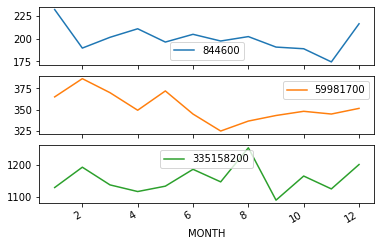

In [31]:
pd.pivot_table(transactions.reset_index(),index='MONTH',columns = 'ITEM_NUMBER',
               values = 'SOLDUNITS').plot(subplots=True)

In [32]:
transactions.groupby(['ITEM_NUMBER'])['SOLDUNITS'].describe()

,count,mean,std,min,25%,50%,75%,max
ITEM_NUMBER,,,,,,,,
844600,14149.0,200.624898,314.088986,0.28571,25.314290,65.400000,244.273970,3733.14286
59981700,59338.0,352.894320,482.061916,0.13342,64.656605,177.782545,405.727848,34217.02703
335158200,3922.0,1156.211129,451.852487,1.00000,1107.966670,1275.555560,1380.957500,2525.57778


844600            AxesSubplot(0.1,0.559091;0.363636x0.340909)
59981700     AxesSubplot(0.536364,0.559091;0.363636x0.340909)
335158200             AxesSubplot(0.1,0.15;0.363636x0.340909)
dtype: object

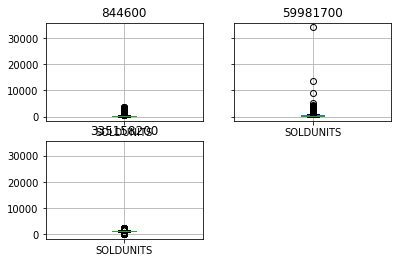

In [33]:
transactions.groupby('ITEM_NUMBER').boxplot(column='SOLDUNITS')

In [34]:
df1, df2, df3 = [x for _, x in transactions.groupby(transactions['ITEM_NUMBER'])]

In [35]:
df1.head()

,ITEM_NUMBER,DATE,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON
0,844600,2013-08-14,2.85714,2013,8,33,14,0,3
1,844600,2013-08-16,15.60000,2013,8,33,16,0,3
2,844600,2013-08-16,15.60000,2013,8,33,16,0,3
3,844600,2013-08-16,716.91429,2013,8,33,16,0,3
4,844600,2013-08-16,153.14286,2013,8,33,16,0,3


In [36]:
df1['DATE'] = pd.to_datetime(df1['DATE'], format='%Y-%m-%d')
df2['DATE'] = pd.to_datetime(df2['DATE'], format='%Y-%m-%d')
df3['DATE'] = pd.to_datetime(df3['DATE'], format='%Y-%m-%d')

In [37]:
filtered_df1 = df1.loc[(df1['DATE'] >= '2021-12-01')
                     & (df1['DATE'] < '2022-05-30')]

In [38]:
filtered_df1.head()

,ITEM_NUMBER,DATE,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON
34,844600,2022-03-25,63.53973,2022,3,12,25,0,2
35,844600,2022-03-26,21.55000,2022,3,12,26,0,2
36,844600,2022-03-26,396.41918,2022,3,12,26,0,2
37,844600,2022-03-28,378.52603,2022,3,13,28,0,2
38,844600,2022-03-28,157.71918,2022,3,13,28,0,2


In [39]:
weekly_df = df1.groupby([pd.Grouper(key='DATE', freq='D')])['SOLDUNITS'].sum()

In [40]:
df = weekly_df.to_frame()

In [41]:
df.reset_index()

,DATE,SOLDUNITS
0,2009-06-24,2.00000
1,2009-06-25,0.00000
2,2009-06-26,0.00000
3,2009-06-27,0.00000
4,2009-06-28,0.00000
...,...,...
4716,2022-05-23,3836.88631
4717,2022-05-24,1166.74795
4718,2022-05-25,389.30137
4719,2022-05-26,1085.27398


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4721 entries, 2009-06-24 to 2022-05-27
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SOLDUNITS  4721 non-null   float64
dtypes: float64(1)
memory usage: 73.8 KB


In [44]:
def decompose_item_demand(df, share_type='SOLDUNITS', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    
    #plot the complete time series
    fig, axs = plt.subplots(2, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    

    plt.show()

In [56]:
def train_time_series_with_folds(df, horizon=24*90):
    dropcolumns = ['SOLDUNITS']
    X = df.drop(dropcolumns, axis=1)
    y = df['SOLDUNITS']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    #print(predictions)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)  
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.scatter(y_test.index,y_test, color='red')
    plt.plot(pd.Series(predictions,index = y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of items sold', fontsize=16)
    plt.legend(labels=['Prediction', 'Real'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    #df_importances = pd.DataFrame({
    #    'feature': model.feature_name_,
    #    'importance': model.feature_importances_
    #}).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    #plt.title('Variable Importances', fontsize=16)
    #sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    #plt.show()

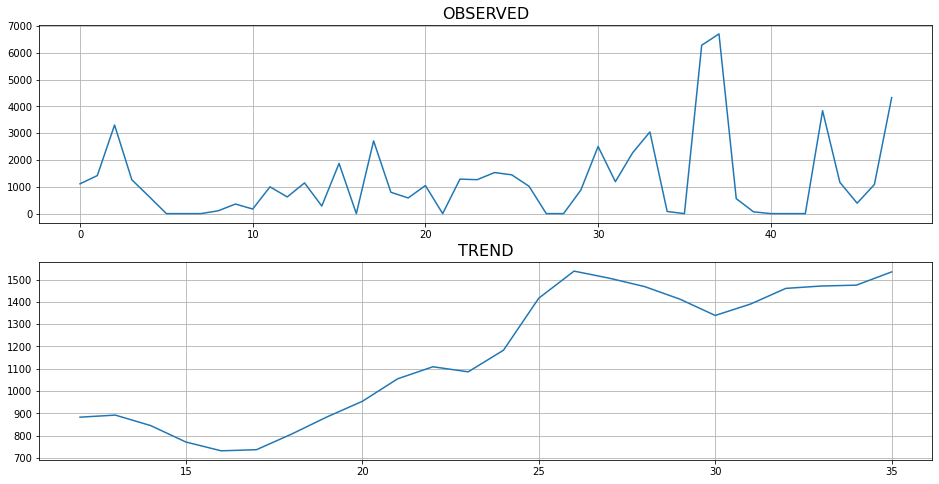

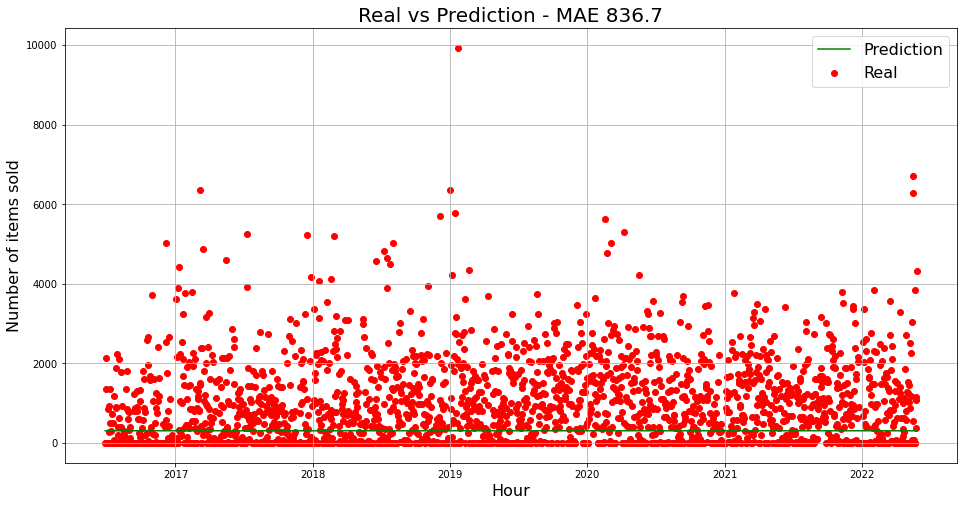

In [57]:
decompose_item_demand(df,samples=48,period=24)
train_time_series_with_folds(df)

In [ ]:
filtered_df2 = df2.loc[(df2['DATE'] >= '2021-12-01')
                     & (df2['DATE'] < '2022-05-30')]

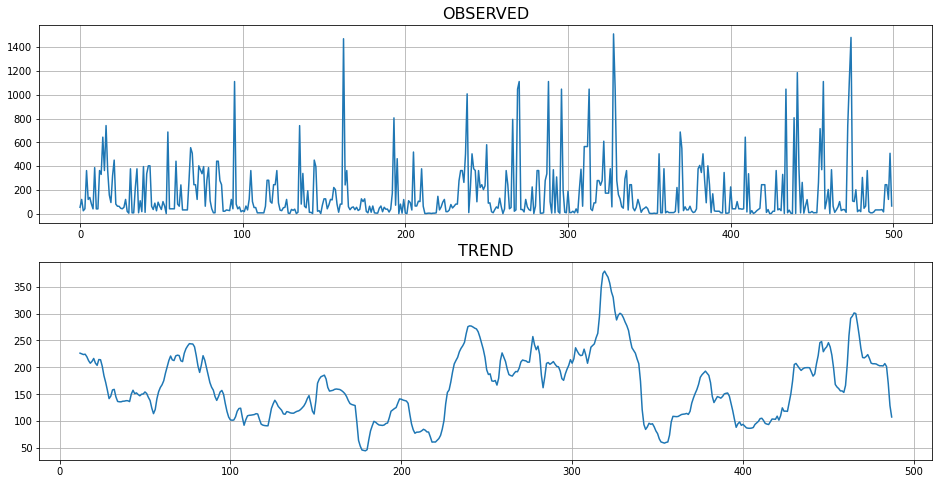

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: DATE

In [55]:
decompose_item_demand(filtered_df1,samples=500,period=24)
train_time_series_with_folds(filtered_df1)

In [ ]:
filtered_df3 = df3.loc[(df3['DATE'] >= '2021-12-01')
                     & (df3['DATE'] < '2022-05-30')]

In [ ]:
decompose_item_demand(filtered_df3,samples=200,period=24)
train_time_series_with_folds(filtered_df3)